# Аналіз заробітних плат та термін роботи працівників компанії з використанням SQL в Python

## Підготовчий етап

1.Встановимо бібліотеку `mysql-connector-python`.

In [26]:
!pip install mysql-connector-python

In [27]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import pandas as pd
import datetime 
import matplotlib.pyplot as plt

2.В змінній `con` створимо підключення до бази даних employees:

In [28]:
con = mysql.connector.connect(user='user1', password='7oygWy6P',
                              host='3.68.62.36',
                              database='employees')

3.Виберемо максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`.

In [29]:
cursor = con.cursor()

sql = """
SELECT max(hire_date), min(hire_date) 
FROM employees 
"""

cursor.execute(sql)

In [30]:
cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

4.Виберемо інформацію про останню ЗП кожного співробіткника в базі. 
Результати запишемо у pandas DataFrame, який збережемо у змінну `res`.

In [31]:
cursor = con.cursor()

sql = """
SELECT salaries.emp_no, salaries.salary, salaries.from_date, salaries.to_date
FROM salaries
INNER JOIN (
    SELECT emp_no, MAX(to_date) AS to_date
    FROM salaries
    GROUP BY emp_no
) AS max_date ON salaries.emp_no = max_date.emp_no AND salaries.to_date = max_date.to_date;
"""

cursor.execute(sql)

In [32]:
field_names = [i[0] for i in cursor.description]

In [33]:
res = pd.DataFrame(cursor.fetchall(), columns=field_names)

In [34]:
display( res.columns,res.head(3),res.shape)

Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')

,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


(300180, 4)

5.В утвореній вибірці в змінній `res` знайдемо скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? 
Для початку перевіримо який тип даних у значень колонки `to_date`. 

In [35]:
type('res.to_date')

str

In [36]:
res['to_date'].dtype

dtype('O')

In [37]:
res.to_date.loc[1]

datetime.date(9999, 1, 1)

In [38]:
count_to_date = (res.to_date == datetime.date(9999, 1, 1)).value_counts()

In [39]:
count_to_date

to_date
True     240124
False     60056
Name: count, dtype: int64

6.Виведемо візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. 

In [40]:
filtered_salaries = res[res.to_date == datetime.date(9999, 1, 1)]

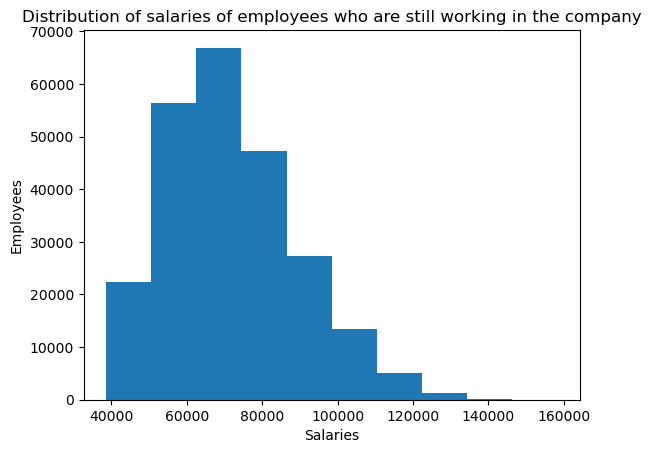

In [41]:
plt.hist(filtered_salaries['salary'])
plt.title('Distribution of salaries of employees who are still working in the company')
plt.xlabel('Salaries')
plt.ylabel('Employees');

7.Виведемо кількість співробітників за роком, в який вони були найняті (`hire_date`) використовуючи `pandas.read_sql`. Запишемо результат в змінну `df` та виведемо значення змінної на екран.

In [42]:
sql_query = """
SELECT year(hire_date) as hire_year, count(emp_no) as emp_num  
FROM employees 
GROUP BY year(hire_date)
"""

In [43]:
df = pd.read_sql_query(sql_query, con)

C:\Users\aivko\AppData\Local\Temp\ipykernel_10424\1926125351.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, con)


In [44]:
df

,hire_year,emp_num
0,1986,36150
1,1985,35316
2,1989,28394
3,1994,14835
4,1990,25610
5,1992,20402
6,1987,33501
7,1995,12115
8,1993,17772
9,1999,1514


8.Виведемо лінійний графік залежності кількості найманих співробітників від року найму. 

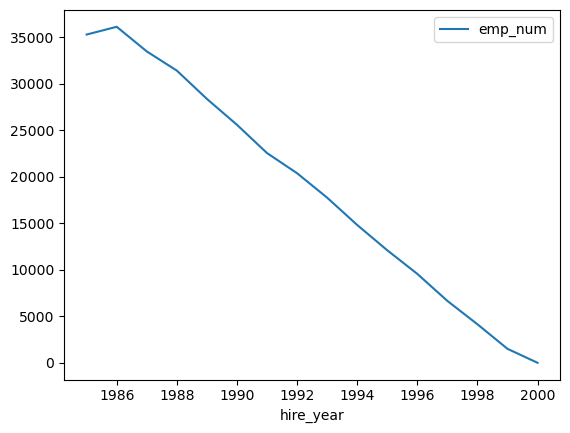

In [45]:
df.sort_values('hire_year').plot(x='hire_year', y='emp_num');

9.З допомогою SQL для робітників позиції `Engineer`, які вже не працюють в компанії знайдемо кількість повних років перебування на позиції. 
Результат запишемо в змінну `df_years` та виведемо цю змінну на екран.

In [46]:
sql = """
SELECT TIMESTAMPDIFF(year, from_date, to_date) duration, from_date, to_date
FROM titles
WHERE title = 'Engineer' and to_date <> '9999-01-01'
"""

In [47]:
df_years = pd.read_sql_query(sql, con)

C:\Users\aivko\AppData\Local\Temp\ipykernel_10424\3233243521.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_years = pd.read_sql_query(sql, con)


In [48]:
print(df_years)

       duration   from_date     to_date
0             9  1986-12-01  1995-12-01
1             5  1990-02-18  1995-02-18
2             8  1992-12-18  2000-12-18
3             8  1987-04-03  1995-04-03
4             5  1995-03-20  2001-03-19
...         ...         ...         ...
84015         9  1989-11-23  1998-11-23
84016         5  1989-07-30  1994-07-30
84017         0  1993-02-22  1993-10-27
84018         6  1996-05-13  2002-05-13
84019         4  1987-08-30  1992-08-29

[84020 rows x 3 columns]


10.Використовуючи дані в  `df_years`, побудуэмо гістограму кількості років, протягом яких люди з назвою позиції `Engineer` перебували на позиції.

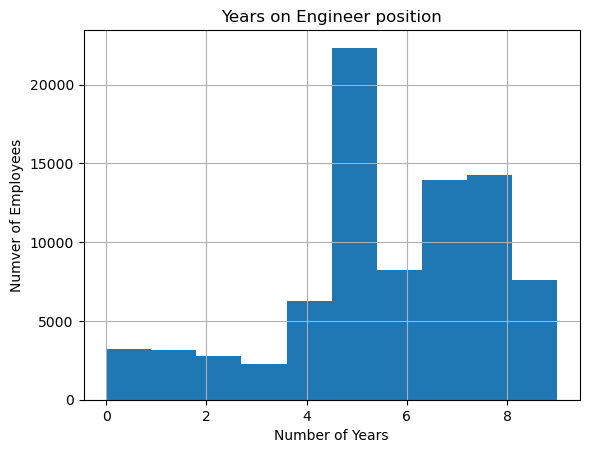

In [49]:
df_years.duration.hist()
plt.title('Years on Engineer position')
plt.ylabel('Numver of Employees')
plt.xlabel('Number of Years');

Закривємо підключення до бази

In [50]:
con.close()